#Rule similarity based on Bag of Word representation

In [1]:
# Import libraries
import pandas as pd
import re
import numpy as np
import seaborn as sns;
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#define rulesets path and destination path 
filepath=""
rulepath=""

In [2]:
# Load the data
#real dataset
ruleset_r=pd.read_csv(rulepath+"ruleset1.csv", header=None) 
ruleset_r['n'] = pd.Series( ruleset_r.index+1).astype("string")
print(ruleset_r.iloc[:,0])
print(ruleset_r.iloc[:,1])
print(ruleset_r.iloc[:,2])
ruleset_r['Rule'] = ruleset_r.apply(lambda x: x[0][x[0].find('IF')+3:x[0].find('THEN')-1], axis=1)
ruleset_r['Covering'] = ruleset_r.apply(lambda x: x[1][x[1].find(':')+2:], axis=1)
ruleset_r['Error'] = ruleset_r.apply(lambda x: x[2][x[2].find(':')+2:], axis=1)
ruleset_r['Class'] = ruleset_r.apply(lambda x: x[0][x[0].find('"')+1:x[0].find('"')+2], axis=1)
ruleset_r.drop(ruleset_r.iloc[:,0:3] , axis=1, inplace=True)
ruleset_r['Set']='real'
print(ruleset_r)

#synthetic dataset
ruleset_s=pd.read_csv(rulepath+"ruleset2.csv", header=None) 
ruleset_s['n'] = pd.Series( ruleset_s.index+1)
ruleset_s['Rule'] = ruleset_s.apply(lambda x: x[0][x[0].find('IF')+3:x[0].find('THEN')-1], axis=1)
ruleset_s['Covering'] = ruleset_s.apply(lambda x: x[1][x[1].find(':')+2:], axis=1)
ruleset_s['Error'] = ruleset_s.apply(lambda x: x[2][x[2].find(':')+2:], axis=1)
ruleset_s['Class'] = ruleset_s.apply(lambda x: x[0][x[0].find('"')+1:x[0].find('"')+2], axis=1)
ruleset_s.drop(ruleset_s.iloc[:,0:3] , axis=1, inplace=True)
ruleset_s['Set']='synth'
print(ruleset_s)

#concatenate real and synthetic rulesets and select rules with covering above 15%
ruleset = pd.concat([ruleset_r, ruleset_s], ignore_index=True)
ruleset=ruleset[ruleset["Covering"].astype('float')>0.15]


0     RULE 1: IF srt <= -4.468994 AND Age <= 84.7538...
1     RULE 2: IF srt > -0.332244 AND Age > 69.860081...
2     RULE 3: IF srt > -13.949663 AND Age > 74.40035...
3     RULE 4: IF srt > -10.029165 AND #correct <= 63...
4     RULE 5: IF srt <= -9.550631 THEN class = "0 pass"
5      RULE 6: IF srt > 13.219239 THEN class = "1 fail"
6     RULE 7: IF -4.175843 < srt <= 10.984783 AND Ag...
7     RULE 8: IF 72.997257 < #correct <= 102.627716 ...
8     RULE 9: IF -4.806845 < srt <= 13.219239 AND tr...
9     RULE 10: IF Age > 69.860081 AND 78.155506 < tr...
10    RULE 11: IF -11.860079 < srt <= -3.285272 AND ...
11    RULE 12: IF 0.598021 < volume <= 0.631316 THEN...
Name: 0, dtype: object
0      COVERING: 0.750000
1      COVERING: 0.683333
2      COVERING: 0.680952
3      COVERING: 0.645238
4      COVERING: 0.576316
5      COVERING: 0.292857
6      COVERING: 0.186842
7      COVERING: 0.155263
8      COVERING: 0.136842
9      COVERING: 0.092857
10     COVERING: 0.016667
11     COVERING: 0.

In [ ]:
def convert_litteral(classe):
    if classe == '1':
        return 'HL'
    else:
        return 'noHL'

In [3]:
ruleset['Class'] = ruleset['Class'].apply(convert_litteral)
ruleset

,n,Rule,Covering,Error,Class,Set
0,1,srt <= -4.468994 AND Age <= 84.753849 AND #cor...,0.750000,0.050000,noHL,real
1,2,srt > -0.332244 AND Age > 69.860081,0.683333,0.042105,HL,real
2,3,srt > -13.949663 AND Age > 74.400352 AND trial...,0.680952,0.044737,HL,real
3,4,srt > -10.029165 AND #correct <= 63.960228,0.645238,0.036842,HL,real
4,5,srt <= -9.550631,0.576316,0.038095,noHL,real
5,6,srt > 13.219239,0.292857,0.002632,HL,real
6,7,-4.175843 < srt <= 10.984783 AND Age <= 74.868...,0.186842,0.047619,noHL,real
7,8,72.997257 < #correct <= 102.627716 AND avg_rea...,0.155263,0.023810,noHL,real
12,1,81.130756 < Age <= 84.536621,0.588670,0.043147,HL,synth
13,2,srt <= -7.247382 AND #correct > 62.437859 AND ...,0.565990,0.049261,noHL,synth


In [4]:
ruleset.reset_index(drop=True, inplace=True)

In [5]:
#extract feature and sign of each condition
from collections import Counter
words = []
unilateral_conditions=[]
for index, value in ruleset.loc[:,'Rule'].items():
    for r in value.split(' AND '): #split each rules in r conditions, based on the splitting variable AND
        if r.count('<')==2:  #if the condition is defined by intervals (n1<x<n2), in order to split them into two unilateral conditions
            second=r[r.find('<')+2:] # second part of the interval x<n2
            words.append(second[:second.find('<')+2].replace(" ", ""))  # extract feature + sign (n1<) of the second part of the interval and removes the cut-off value
            feat=second[:second.find('<')] #extract the feature name
            if r.find('<')+1== '=': 
                first=feat+'>= '+r[:r.find('<')] # first condition n1<=x-> x>=n1
            else:
                first=feat+'> '+r[:r.find('<')] # first condition n1<x-> x>n1
                
            words.append(first[:first.find('>')+2].replace(" ", ""))  # extract feature + sign (n1>= or n1>) of the first part of the interval and removes the cut-off value  
            #split and save intervals as 2 unilateral conditions
            unilateral_conditions.append(second);
            unilateral_conditions.append(first);
        elif r.find('>')>0: # else if the condition is unilateral, in the form x>
            unilateral_conditions.append(r);
            words.append(r[:r.find('>')+2].replace(" ", ""))            
        else: # else if the condition is unilateral, in the form x<
            unilateral_conditions.append(r);
            words.append(r[:r.find('<')+2].replace(" ", ""))
print(words)
counter = Counter(words) #vector that store the list of words (unique) and their occurrence
print(counter)

['srt<=', 'Age<=', '#correct>', 'srt>', 'Age>', 'srt>', 'Age>', 'trials<=', 'srt>', '#correct<=', 'srt<=', 'srt>', 'srt<=', 'srt>', 'Age<=', '#correct>', '#correct<=', '#correct>', 'avg_reaction_time<=', 'Age<=', 'Age>', 'srt<=', '#correct>', 'avg_reaction_time<=', 'avg_reaction_time>', 'srt<=', 'srt>', 'Age<=', 'Age>', 'avg_reaction_time>', 'srt>', 'Age>', '#correct<=', 'avg_reaction_time<=', 'avg_reaction_time>', 'srt<=', 'srt>', 'Age<=']
Counter({'srt>': 8, 'srt<=': 6, 'Age<=': 5, 'Age>': 5, '#correct>': 4, '#correct<=': 3, 'avg_reaction_time<=': 3, 'avg_reaction_time>': 3, 'trials<=': 1})


In [6]:
for i in counter: #for each word in the list creates three new colums in the ruleset: one for presence/absence of the word in the rule, one for the cut-off value and one for the normalized cut-off value 
    ruleset.loc[:,i]= 0
    ruleset[i+'Value']=0.0
    ruleset[i+'ValueNorm']=0.0

In [7]:
#for each word fill the correspondent column with 1 is the word is present in the rule, in that case, fill the value column with the correspondent cut-off value
for c in counter:
    for index, value in ruleset.loc[:,'Rule'].items():
        
        for r in value.split(' AND '): #for each single condition
            if r.count('<')==2:  #search for conditions defined by intervals (n1<x<n2)
                second=r[r.find('<')+2:] 
                feat=second[:second.find('<')] 
                if r.find('<')+1== '=': 
                    first=feat+'>= '+r[:r.find('<')] #first condition n1<=x-> x>=n1
                else:
                    first=feat+'> '+r[:r.find('<')] #first condition n1<x-> x>n1
                if first[:first.find('>')+2].replace(" ", "") == c:
                    ruleset.loc[index, c] = 1 
                    ruleset.loc[index, c+'Value'] = float(first.split('>')[1].strip())    
                if second[:second.find('<')+2].replace(" ", "") == c:
                    ruleset.loc[index, c] = 1
                    if second.find('='):
                        ruleset.loc[index, c+'Value'] = float(second.split('<=')[1].strip()) 
                    else:   
                        ruleset.loc[index, c+'Value'] = float(second.split('<')[1].strip())           
            elif r[:r.find('>')+2].replace(" ", "") == c:
                ruleset.loc[index, c] = 1
                ruleset.loc[index, c+'Value'] = float(r.split('>')[1].strip())
            elif r[:r.find('<')+2].replace(" ", "") == c:
                ruleset.loc[index, c] = 1
                ruleset.loc[index, c+'Value'] = float(r.split('<=')[1].strip())
print(ruleset)               

    n                                               Rule  Covering     Error  \
0   1  srt <= -4.468994 AND Age <= 84.753849 AND #cor...  0.750000  0.050000   
1   2                srt > -0.332244 AND Age > 69.860081  0.683333  0.042105   
2   3  srt > -13.949663 AND Age > 74.400352 AND trial...  0.680952  0.044737   
3   4         srt > -10.029165 AND #correct <= 63.960228  0.645238  0.036842   
4   5                                   srt <= -9.550631  0.576316  0.038095   
5   6                                    srt > 13.219239  0.292857  0.002632   
6   7  -4.175843 < srt <= 10.984783 AND Age <= 74.868...  0.186842  0.047619   
7   8  72.997257 < #correct <= 102.627716 AND avg_rea...  0.155263  0.023810   
8   1                       81.130756 < Age <= 84.536621  0.588670  0.043147   
9   2  srt <= -7.247382 AND #correct > 62.437859 AND ...  0.565990  0.049261   
10  3  -18.185668 < srt <= -2.447426 AND 23.723455 < ...  0.505076  0.049261   
11  4                       avg_reaction

In [8]:
#Vectors of maximum and minimum (normative) values for each feature that will be hardly never present in a classification rule
feature_names= ['srt', 'Age', 'trials', 'correct', '%correct', 'avg_reaction_time', 'total_test_time', 'volume']
minVet=[-25,0,20,15,0,0.5,100,1]
maxVet=[25,99,150,125,100,10,180,0.9] 
for c in counter: #normalize each column value between 0 and 1 by considering minimum and maximum possible values (hardly never achieved)  
    for feat in feature_names: #for each feature
        if c.count(feat)==1: 
            maxFeat=maxVet[feature_names.index(feat)]
            minFeat=minVet[feature_names.index(feat)]
    valueColIndex=ruleset.columns.get_loc(c)+1
    for rowIndex, value in ruleset.iloc[:,valueColIndex].items():
        if ruleset.iloc[rowIndex, valueColIndex]==0: #when the word column is zero
            ruleset.iloc[rowIndex, valueColIndex+1] =0 #also the value column is 0 (as the minimum is never present in a classification rule, we have value 0 only if the word is not present)
        else:
            ruleset.iloc[rowIndex, valueColIndex+1] = (ruleset.iloc[rowIndex, valueColIndex]-minFeat)/(maxFeat-minFeat) #normalize between min and max
for c in counter: #reset the cut-off value column and keeps only the normalized values
    del ruleset[c+'Value'] 
print(ruleset)

    n                                               Rule  Covering     Error  \
0   1  srt <= -4.468994 AND Age <= 84.753849 AND #cor...  0.750000  0.050000   
1   2                srt > -0.332244 AND Age > 69.860081  0.683333  0.042105   
2   3  srt > -13.949663 AND Age > 74.400352 AND trial...  0.680952  0.044737   
3   4         srt > -10.029165 AND #correct <= 63.960228  0.645238  0.036842   
4   5                                   srt <= -9.550631  0.576316  0.038095   
5   6                                    srt > 13.219239  0.292857  0.002632   
6   7  -4.175843 < srt <= 10.984783 AND Age <= 74.868...  0.186842  0.047619   
7   8  72.997257 < #correct <= 102.627716 AND avg_rea...  0.155263  0.023810   
8   1                       81.130756 < Age <= 84.536621  0.588670  0.043147   
9   2  srt <= -7.247382 AND #correct > 62.437859 AND ...  0.565990  0.049261   
10  3  -18.185668 < srt <= -2.447426 AND 23.723455 < ...  0.505076  0.049261   
11  4                       avg_reaction

In [9]:
# divide the rules by class as only rules characterizing the same output class will be compared
ruleset_HL=ruleset[ruleset['Class']=='HL']
ruleset_noHL=ruleset[ruleset['Class']=='noHL']
print(ruleset_HL)

    n                                               Rule  Covering     Error  \
1   2                srt > -0.332244 AND Age > 69.860081  0.683333  0.042105   
2   3  srt > -13.949663 AND Age > 74.400352 AND trial...  0.680952  0.044737   
3   4         srt > -10.029165 AND #correct <= 63.960228  0.645238  0.036842   
5   6                                    srt > 13.219239  0.292857  0.002632   
8   1                       81.130756 < Age <= 84.536621  0.588670  0.043147   
11  4                       avg_reaction_time > 3.289759  0.463054  0.048223   
12  5  srt > -1.658821 AND Age > 42.986900 AND #corre...  0.428571  0.048223   

   Class    Set  srt<=  srt<=ValueNorm  Age<=  Age<=ValueNorm  #correct>  \
1     HL   real      0             0.0      0        0.000000          0   
2     HL   real      0             0.0      0        0.000000          0   
3     HL   real      0             0.0      0        0.000000          0   
5     HL   real      0             0.0      0        0.

In [10]:
#convert the columns of the BOW matrix into arrays to compute cosine similarity
matrix_noHL = ruleset_noHL.iloc[:,6:ruleset_noHL.shape[1]].to_numpy()
matrix_HL = ruleset_HL.iloc[:,6:ruleset_HL.shape[1]].to_numpy()

In [11]:
#calculate cosine similarity of the BOW matrixes, one for each output class
cos_sim_noHL = cosine_similarity (matrix_noHL, matrix_noHL)
cos_sim_HL = cosine_similarity (matrix_HL, matrix_HL)

In [12]:
# Matrixes of cosine similarity between rules, max similarity=1 (same rule) 
#the cell in position i,j cointains the similarity coefficient between rule i and rule j
similarity_matrix_noHL = pd.DataFrame(cos_sim_noHL,
                   index = ruleset_noHL['Set'] +' - Rule: ' +  ruleset_noHL['n'].astype("string"),
                   #index=phrases,
                   columns = ruleset_noHL['Set'] + ' - Rule: ' + ruleset_noHL['n'].astype("string"))
                   #columns=phrases)
similarity_matrix_HL = pd.DataFrame(cos_sim_HL,
                   index = ruleset_HL['Set'] +' - Rule: ' + ruleset_HL['n'].astype("string"),
                   #index=phrases,
                   columns = ruleset_HL['Set'] + ' - Rule: '  + ruleset_HL['n'].astype("string"))
                   #columns=phrases)

print(similarity_matrix_noHL)
print(similarity_matrix_HL)

                 real - Rule: 1  real - Rule: 5  real - Rule: 7  \
real - Rule: 1         1.000000        0.535851        0.873020   
real - Rule: 5         0.535851        1.000000        0.503537   
real - Rule: 7         0.873020        0.503537        1.000000   
real - Rule: 8         0.300244        0.000000        0.256971   
synth - Rule: 2        0.547593        0.506186        0.494542   
synth - Rule: 3        0.645510        0.489421        0.775242   
synth - Rule: 6        0.704633        0.578568        0.889044   

                 real - Rule: 8  synth - Rule: 2  synth - Rule: 3  \
real - Rule: 1         0.300244         0.547593         0.645510   
real - Rule: 5         0.000000         0.506186         0.489421   
real - Rule: 7         0.256971         0.494542         0.775242   
real - Rule: 8         1.000000         0.542002         0.000000   
synth - Rule: 2        0.542002         1.000000         0.249020   
synth - Rule: 3        0.000000         0.249020 

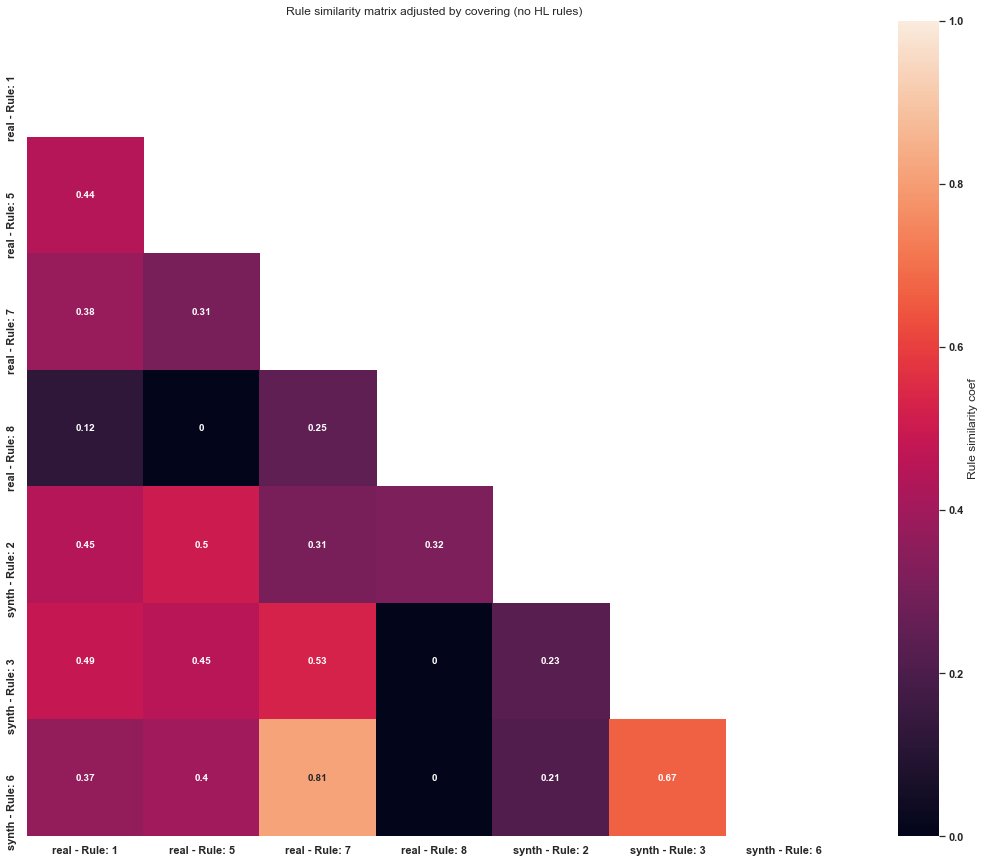

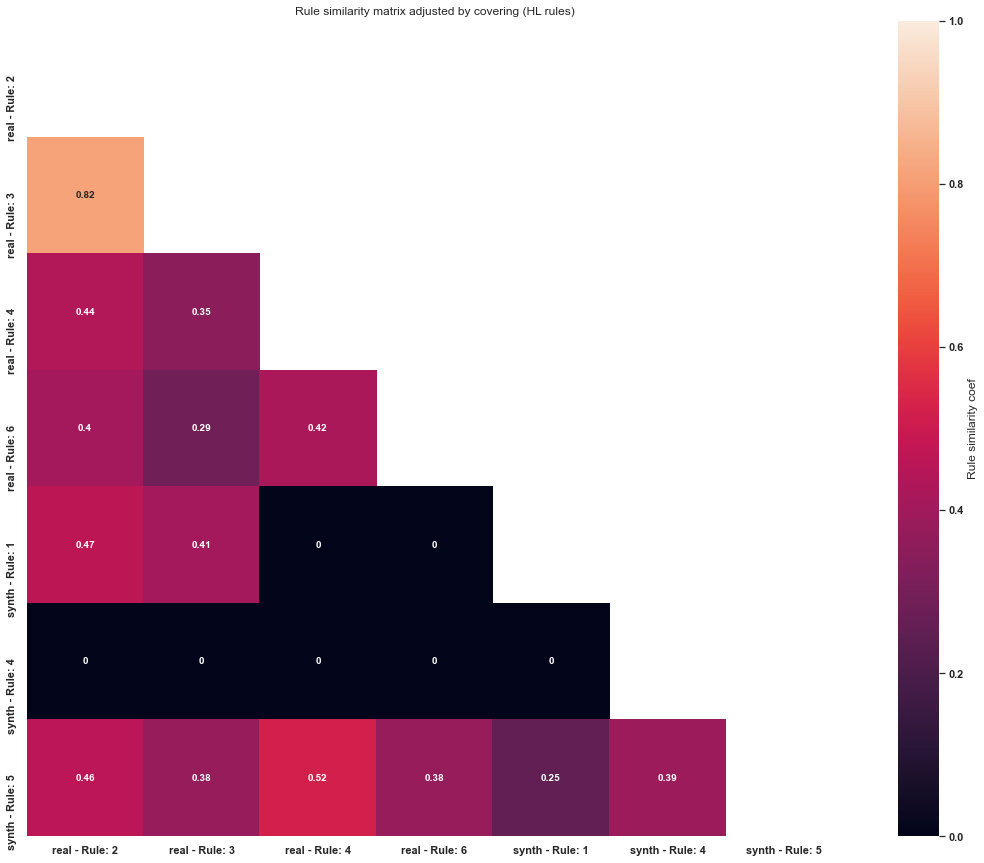

In [13]:
#Adjust rule similarity by considering covering differences between rules: max similarity=1 (same rule structure and covering) 
# no HL
ruleset_noHL.reset_index(drop=True, inplace=True)
cov_as_float=ruleset_noHL['Covering'].astype('float') #vector of covering values for rules describing the no HL class

for i in range (similarity_matrix_noHL.shape[1]):    
    for j in range (similarity_matrix_noHL.shape[1]):       
        if(similarity_matrix_noHL.iat[i,j]!=0): #if the rule similarity of a couple of rule i,j is not zero
            tmp=1-(abs(cov_as_float[i]-cov_as_float[j])) 
            similarity_matrix_noHL.iat[i,j]= similarity_matrix_noHL.iat[i,j]*tmp #adjust rule similarity coefficient between rule i and j
            

#%matplotlib notebook 
sns.set_theme()
font = {'family' : 'normal','weight' : 'bold','size'   : 10}
matplotlib.rc('font', **font)

#PLOT THE RULE SIMILARITY MATRIX FOR NO HL RULES
mask = np.zeros_like(similarity_matrix_noHL)
mask[np.triu_indices_from(mask)] = True #plots only lower triangular matrix (the matrix is simmetric)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(similarity_matrix_noHL, mask=mask, square=True,cbar_kws={'label': 'Rule similarity coef'},vmin=0, vmax=1,annot=True)
    ax.set_title('Rule similarity matrix adjusted by covering (no HL rules)')

# HL
ruleset_HL.reset_index(drop=True, inplace=True)
cov_as_float=ruleset_HL['Covering'].astype('float') #vector of covering values for rules describing the HL class
for i in range (similarity_matrix_HL.shape[1]):    
    for j in range (similarity_matrix_HL.shape[1]):       
        if(similarity_matrix_HL.iat[i,j]!=0):
            tmp=1-(abs(cov_as_float[i]-cov_as_float[j]))
            similarity_matrix_HL.iat[i,j]= similarity_matrix_HL.iat[i,j]*tmp #adjust rule similarity coefficient 
            
#PLOT THE RULE SIMILARITY MATRIX FOR NO HL RULES
mask = np.zeros_like(similarity_matrix_HL)
mask[np.triu_indices_from(mask)] = True #plots only lower triangular matrix (the matrix is simmetric)
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(20, 15))
    ax = sns.heatmap(similarity_matrix_HL, mask=mask, square=True,cbar_kws={'label': 'Rule similarity coef'},vmin=0, vmax=1,annot=True)
    ax.set_title('Rule similarity matrix adjusted by covering (HL rules)')

In [14]:
#save to Excel
similarity_matrix_HL.to_excel(filepath+'Rule_similarity.xlsx', sheet_name='HL',index=True)
similarity_matrix_noHL.to_excel(filepath+'Rule_similarity.xlsx', sheet_name='noHL',index=True)